# Group Members: Sreejony Sengupta, Shahmir Javed, Rizvee Ahmed, Nathan Arimilli, Brendan Hendricks, Pranit Yadav

Install necessary packages

In [ ]:
!pip install selenium
!apt-get -q update
!apt install -yq chromium-chromedriver
!pip install webdriver-manager beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRel

Webscrape from Edmunds.com using Selenium and Chromium. Scrapes for 10,000 observations. Gets userid, date, and comments. Saves the scrapped data into a csv for further processing.

In [ ]:
import csv
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import sys
import os

def scrape_forum(forum_url, post_limit=10000):
    """
    Scrapes the Edmunds.com forum for messages and saves them to a CSV file using Selenium.

    Args:
        forum_url (str): The base URL of the forum thread.
        post_limit (int): The target number of posts to scrape.
    """
    # Installation commands for Colab/Jupyter environment
    try:
        print("Installing necessary packages...")
        # Note: The `!` is a Jupyter/Colab specific command to run shell commands.
        os.system('pip install selenium webdriver-manager beautifulsoup4')
        os.system('pip install google-colab-selenium')

        # Add the ChromeDriver directory to Python's search path
        sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')
        print("Packages installed successfully.")
    except Exception as e:
        print(f"Error during package installation: {e}")
        return

    # Set up Chrome options to run in headless mode
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--remote-debugging-port=9222')
    options.add_argument('--disable-gpu')
    options.add_argument('--window-size=1920,1080')
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

    try:
        # Use a simplified method for Colab environments
        from google_colab_selenium import Chrome
        driver = Chrome()
    except Exception as e:
        print(f"Failed to set up WebDriver: {e}")
        print("Please ensure you have Google Chrome installed or check your Colab environment.")
        return

    all_posts = []
    current_url = forum_url
    post_count = 0

    print(f"Starting to scrape the forum. Target post count: {post_limit}")
    print("Scraping will stop once the number of posts is between 8,000 and 10,000.")

    # Loop to paginate through the forum until the post limit is reached
    while current_url and post_count < post_limit:
        print(f"Fetching page: {current_url}")

        try:
            driver.get(current_url)
            time.sleep(0)

            # Use BeautifulSoup to parse the page source
            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Find all post elements on the current page
            posts_on_page = soup.find_all('li', class_='Item')

            if not posts_on_page:
                print("No more posts found. Stopping scrape.")
                break

            for post in posts_on_page:
                if post_count >= post_limit:
                    break

                try:
                    # Extract user ID
                    user_element = post.find('a', class_='Username')
                    user_id = user_element.get_text(strip=True) if user_element else 'N/A'

                    # Extract date using the 'datetime' attribute from the 'time' tag
                    date_element = post.find('time')
                    date = date_element['datetime'] if date_element and 'datetime' in date_element.attrs else 'N/A'

                    # Extract message, handling replies by removing blockquotes
                    message_element = post.find('div', class_='Message')
                    if message_element:
                        # Remove blockquote elements to avoid duplicated or quoted content
                        for blockquote in message_element.find_all('blockquote'):
                            blockquote.extract()

                        message = message_element.get_text(strip=True, separator='\n')
                    else:
                        message = 'N/A'

                    all_posts.append({'userid': user_id, 'date': date, 'message': message})
                    post_count += 1
                except Exception as e:
                    print(f"Skipping a post due to an error during parsing: {e}")
                    continue

            print(f"Posts scraped so far: {post_count}")

            # Find the next page URL using the 'rel="next"' attribute
            next_page_link = driver.find_elements(By.XPATH, '//a[@rel="next"]')
            if next_page_link:
                current_url = next_page_link[0].get_attribute('href')
                time.sleep(0)
            else:
                print("No 'Next' button found. Stopping scrape.")
                break

        except Exception as e:
            print(f"An error occurred while fetching the page: {e}")
            break

    driver.quit()  # Close the browser

    # Save data to CSV file
    csv_file = 'edmunds_forum_posts.csv'
    with open(csv_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['userid', 'date', 'message'])
        writer.writeheader()
        writer.writerows(all_posts)

    print(f"Scraping complete. Saved {post_count} posts to {csv_file}")

    # Instructions for downloading the file in Google Colab
    print("\nTo download the CSV file from your Colab session, run the following code in a new cell:")
    print("from google.colab import files")
    print("files.download('edmunds_forum_posts.csv')")

if __name__ == "__main__":
    forum_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
    scrape_forum(forum_url, post_limit=10000)


Installing necessary packages...
Packages installed successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Starting to scrape the forum. Target post count: 10000
Scraping will stop once the number of posts is between 8,000 and 10,000.
Fetching page: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans
Posts scraped so far: 50
Fetching page: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p2
Posts scraped so far: 100
Fetching page: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p3
Posts scraped so far: 150
Fetching page: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p4
Posts scraped so far: 200
Fetching page: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p5
Posts scraped so far: 250
Fetching page: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p6
Posts scraped so far: 300
Fetching page: https://forums.edmunds.com/discussion/2864/general/

In [ ]:
# Optional: Run to download the CSV file from Google Colab to your desktop
from google.colab import files
files.download('edmunds_forum_posts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
BMW = [
    "2 Series", "3 Series", "4 Series", "5 Series", "7 Series", "8 Series", "M2", "M3", "M4", "M5", "M8", "ALPINA B8",
    "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X4 M", "X5 M", "X6 M", "X7 M", "XM",
    "i4", "i7", "iX" , "Bimmer", "Beemer"
]

Mercedes_Benz = [
    "A-Class", "C-Class", "CLA-Class", "E-Class", "S-Class", "AMG GT", "EQS Sedan",
    "GLA-Class", "GLB-Class", "GLC-Class", "GLE-Class", "GLS-Class", "G-Class", "EQB", "EQE", "EQS SUV",
    "Metris", "Sprinter", "E-Class Wagon",
    "Maybach GLS", "AMG G-Class", "AMG E 53", "AMG S 63", "Benz", "Merc"
]

Audi = [
    "A3", "A4", "A5", "A6", "A7", "A8", "S3", "S4", "S5", "S6", "S7", "S8", "RS 3", "RS 5", "RS 7", "RS e-tron GT",
    "Q3", "Q4 e-tron", "Q5", "Q5 Sportback", "Q6 e-tron", "Q7", "Q8", "Q8 e-tron", "SQ5", "SQ7", "SQ8", "RS Q8",
    "e-tron GT", "Q4 e-tron", "Q6 e-tron"
]

Acura = [
    "ILX", "TLX", "TLX Type S", "Integra",
    "RDX", "MDX", "MDX Type S", "ZDX", "ADX"
]

Lexus = [
    "IS", "ES", "GS", "LS", "RC", "RC F", "LC", "LC Convertible",
    "UX", "NX", "RX", "RX Hybrid", "RX Plug-in Hybrid", "RX 500h", "GX", "LX", "TX", "TX Hybrid", "TX Plug-in Hybrid",
    "RZ"
]

INFINITI = [
    "Q50", "Q60",
    "QX50", "QX55", "QX60", "QX80",
    "Red Sport 400 (Q50, Q60)"
]

Tesla = [
    "Model 3", "Model S", "Model Y", "Model X", "Cybertruck"
]

Hyundai = [
    "Elantra", "Elantra N", "Sonata", "Sonata Hybrid",
    "Venue", "Kona", "Kona Electric", "Tucson", "Tucson Hybrid", "Tucson Plug-in Hybrid", "Santa Fe", "Santa Fe Hybrid",
    "Santa Fe Plug-in Hybrid", "Palisade",
    "N Line variants"
]

Kia = [
    "Rio", "Forte", "K5", "Stinger",
    "Seltos", "Sportage", "Sportage Hybrid", "Sportage Plug-in Hybrid", "Niro", "Niro Hybrid", "Niro Plug-in Hybrid",
    "Sorento", "Sorento Hybrid", "Sorento Plug-in Hybrid", "Telluride",
    "Stinger GT"
]

Mazda = [
    "Mazda3", "Mazda6", "CX-30",
    "CX-3", "CX-5", "CX-50", "CX-9", "CX-90",
    "Mazda3 Turbo", "CX-50 Turbo"
]

Cadillac = [
    "CT4", "CT5", "CT5-V", "CT5-V Blackwing",
    "XT4", "XT5", "XT6", "XT6-V", "Escalade", "Escalade ESV", "Lyriq",
    "V-Series" , "Caddy"
]

###Task A
Count frequencies and rank the words using Zipf's law. Fit the calculated ranks to a log-log distribution to test Zipf's law. From our results, the calculated ranks roughly fits with on the log-log distribution which is in accordance to Zipf's law.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NLTK stopwords downloaded.
Total tokens (including stop words): 942,400 | Unique tokens (including stop words): 24,501

=== Zipf Econometric Test (including stop words) ===
slope (beta1_hat)    : -1.5160  (=> s_hat = 1.5160)
intercept (beta0_hat): 1.2868  (=> C_hat = exp(intercept) = 3.621)
R^2                  : 0.9784
t-stat for H0: s=1   : -358.852
p-value (two-sided)  : 0
N (unique tokens): 24,501
95% CI for s         : [1.513, 1.519]


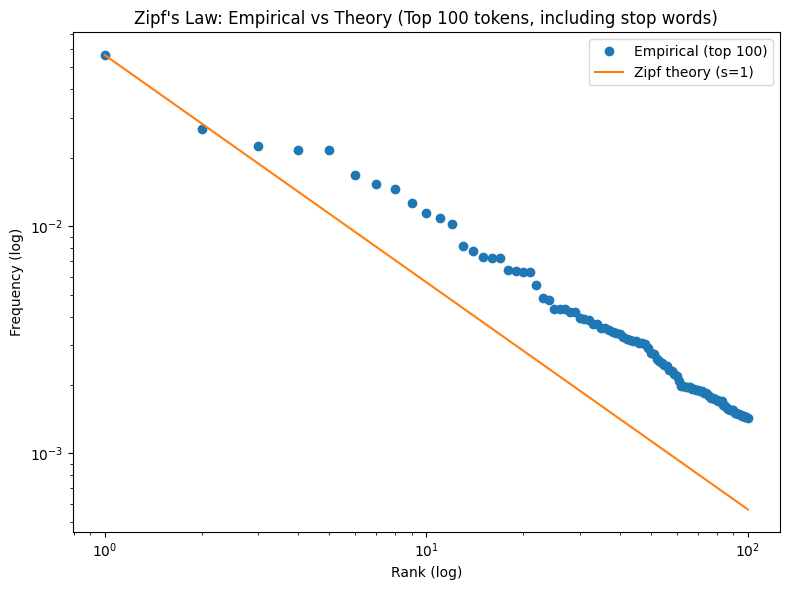

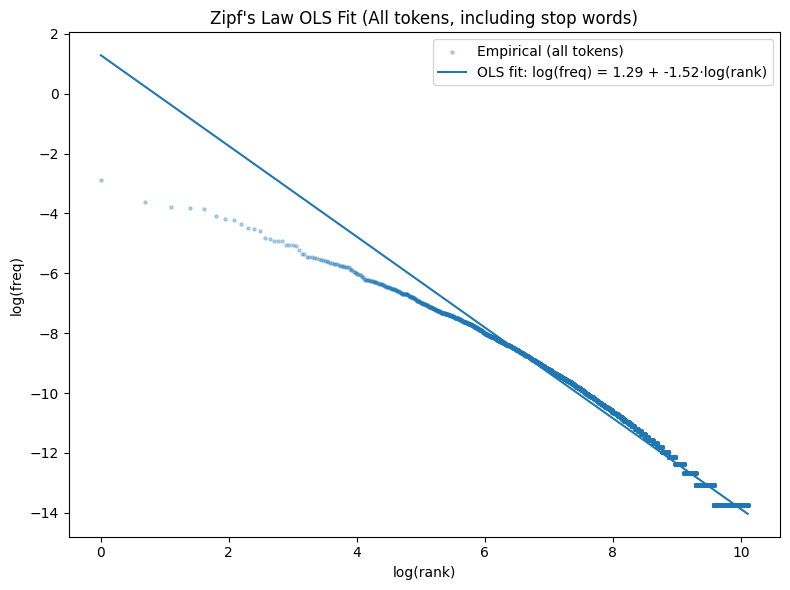

In [ ]:
# --- Imports
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")

english_stopwords = set(stopwords.words('english'))


# Plot config
plt.rcParams['figure.figsize'] = (8, 6)

# --- Config
PATH_TO_SCRAPED = "edmunds_forum_posts.csv"    # produced by your scraper
TEXT_COL = "message"                         # text column name
MIN_WORD_LEN = 1
TOP_K = 100                                  # for the 1/r comparison plot


# --- 1) Load scraped posts
df = pd.read_csv(PATH_TO_SCRAPED)
assert TEXT_COL in df.columns, f"Expected '{TEXT_COL}' column in {PATH_TO_SCRAPED}."

# Optional: drop clearly empty messages
df = df[df[TEXT_COL].astype(str).str.strip().ne("")].copy()

# --- 2) Tokenize all words (including stop words)
word_re = re.compile(r"\b[\w']+\b", flags=re.UNICODE)

def tokenize_all_words(text: str):
    if not isinstance(text, str):
        return []
    # Convert to lowercase and find words
    words = word_re.findall(text.lower())
    # Keep all words that meet the minimum length
    return [word for word in words if len(word) >= MIN_WORD_LEN]


tokens = []
for msg in df[TEXT_COL].fillna(""):
    tokens.extend(tokenize_all_words(msg))

total_tokens = len(tokens)
unique_tokens = len(set(tokens))
print(f"Total tokens (including stop words): {total_tokens:,} | Unique tokens (including stop words): {unique_tokens:,}")


# --- 3) Frequency counts and ranks
freq = Counter(tokens)
ranked = sorted(freq.items(), key=lambda x: x[1], reverse=True)

zipf_df = pd.DataFrame(ranked, columns=["word", "count"])
zipf_df["rank"] = np.arange(1, len(zipf_df) + 1)
zipf_df["freq"] = zipf_df["count"] / zipf_df["count"].sum()

# --- 4) Econometric test of Zipf’s law
# Model: log(freq) = log(C) - s*log(rank)  ==> slope = -s
zipf_df["log_rank"] = np.log(zipf_df["rank"])
zipf_df["log_freq"] = np.log(zipf_df["freq"])

res = linregress(zipf_df["log_rank"].values, zipf_df["log_freq"].values)
beta0_hat = res.intercept
beta1_hat = res.slope      # should be ~ -1 if Zipf holds
stderr_beta1 = res.stderr
n = len(zipf_df)
dfree = n - 2
s_hat = -beta1_hat

print("\n=== Zipf Econometric Test (including stop words) ===")
print(f"slope (beta1_hat)    : {beta1_hat:.4f}  (=> s_hat = {-beta1_hat:.4f})")
print(f"intercept (beta0_hat): {beta0_hat:.4f}  (=> C_hat = exp(intercept) = {np.exp(beta0_hat):.4g})")
print(f"R^2                  : {res.rvalue**2:.4f}")

p_val = 2 * t.sf(np.abs((beta1_hat - (-1)) / stderr_beta1), dfree) if stderr_beta1 else float('nan')
t_stat = (beta1_hat - (-1)) / stderr_beta1 if stderr_beta1 else float('nan')

print(f"t-stat for H0: s=1   : {t_stat:.3f}")
print(f"p-value (two-sided)  : {p_val:.4g}")
print(f"N (unique tokens): {n:,}")

# 95% CI for s
if stderr_beta1:
    crit = t.ppf(0.975, dfree)
    beta1_lo, beta1_hi = beta1_hat - crit*stderr_beta1, beta1_hat + crit*stderr_beta1
    s_lo, s_hi = -beta1_hi, -beta1_lo
    print(f"95% CI for s         : [{s_lo:.3f}, {s_hi:.3f}]")
else:
    print("Cannot calculate 95% CI for s due to zero standard error.")

# --- 5) Plot empirical vs theoretical (top 100) on log-log axes
top = zipf_df.head(TOP_K).copy()
if not top.empty:
    f_max = top["freq"].iloc[0]
    top["zipf_theory_freq"] = f_max / top["rank"]  # Zipf s=1

    plt.figure()
    plt.loglog(top["rank"], top["freq"], marker="o", linestyle="", label="Empirical (top 100)")
    plt.loglog(top["rank"], top["zipf_theory_freq"], linestyle="-", label="Zipf theory (s=1)")
    plt.xlabel("Rank (log)")
    plt.ylabel("Frequency (log)")
    plt.title("Zipf's Law: Empirical vs Theory (Top 100 tokens, including stop words)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough unique tokens to plot the top 100.")


# --- 6) Diagnostic plot: OLS line over all words in log-log space
if not zipf_df.empty:
    x_all = zipf_df["log_rank"].values
    y_fit = beta0_hat + beta1_hat * x_all

    plt.figure()
    plt.scatter(zipf_df["log_rank"], zipf_df["log_freq"], s=5, alpha=0.3, label="Empirical (all tokens)")
    plt.plot(zipf_df["log_rank"], y_fit, label=f"OLS fit: log(freq) = {beta0_hat:.2f} + {beta1_hat:.2f}·log(rank)")
    plt.xlabel("log(rank)")
    plt.ylabel("log(freq)")
    plt.title("Zipf's Law OLS Fit (All tokens, including stop words)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough unique tokens to plot the OLS fit.")

To test if the data support's Zipf's law econometrically, we regressed the log frequency on log rank. Here we saw that the estimatd slope was close to -1 ( ~ -1.5) which supports the theoretical prediction of Zipf's law. The R^2 value was also high at 0.97 and the t-test for null hypothesis indicated that we cannot reject Zipf's law.

Additionally, we plotted the top 100 words in a log-log space against the Zipf's law curve, and saw that this followed a nearly linear trend on the log-log scale. This was especially the case for the most frequent words.

The results suggest that the data is consistent with Zipf's law with word frequencies also roughly decreasing in inverse proportion to their rank.

### Task B

Frequency table for all counts removing stop words and converting car models to brands.

Then converts model counts to brand count, brand each occurence once per comment, removes stopwords, and ranks the top 10 brands.

In [ ]:
# --- Imports
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
import nltk
from nltk.corpus import stopwords
from itertools import combinations

# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")

english_stopwords = set(stopwords.words('english'))


# Plot config
plt.rcParams['figure.figsize'] = (8, 6)

# --- Config
PATH_TO_SCRAPED = "edmunds_forum_posts.csv"    # produced by your scraper
TEXT_COL = "message"                         # text column name
MIN_WORD_LEN = 1
TOP_K = 100                                  # for the 1/r comparison plot


# Define the car brands and models dictionary
ALL_CAR_BRANDS = {
    "BMW": ["2 Series", "3 Series", "4 Series", "5 Series", "7 Series", "8 Series", "M2", "M3", "M4", "M5", "M8", "ALPINA B8",
            "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X4 M", "X5 M", "X6 M", "X7 M", "XM",
            "i4", "i7", "iX", "Bimmer", "Beemer", "BMW"],
    "Mercedes-Benz": ["A-Class", "C-Class", "CLA-Class", "E-Class", "S-Class", "AMG GT", "EQS Sedan",
                      "GLA-Class", "GLB-Class", "GLC-Class", "GLE-Class", "GLS-Class", "G-Class", "EQB", "EQE", "EQS SUV",
                      "Metris", "Sprinter", "E-Class Wagon",
                      "Maybach GLS", "AMG G-Class", "AMG E 53", "AMG S 63", "Benz", "Merc", "MERCEDES-BENZ"],
    "Audi": ["A3", "A4", "A5", "A6", "A7", "A8", "S3", "S4", "S5", "S6", "S7", "S8", "RS 3", "RS 5", "RS 7", "RS e-tron GT",
             "Q3", "Q4 e-tron", "Q5", "Q5 Sportback", "Q6 e-tron", "Q7", "Q8", "Q8 e-tron", "SQ5", "SQ7", "SQ8", "RS Q8",
             "e-tron GT", "Q4 e-tron", "Q6 e-tron", "AUDI"],
    "Acura": ["ILX", "TLX", "TLX Type S", "Integra",
              "RDX", "MDX", "MDX Type S", "ZDX", "ADX", "ACURA", "TL"],
    "Lexus": ["IS", "ES", "GS", "LS", "RC", "RC F", "LC", "LC Convertible",
              "UX", "NX", "RX", "RX Hybrid", "RX Plug-in Hybrid", "RX 500h", "GX", "LX", "TX", "TX Hybrid", "TX Plug-in Hybrid",
              "RZ", "LEXUS"],
    "INFINITI": ["Q50", "Q60",
                 "QX50", "QX55", "QX60", "QX80",
                 "Red Sport 400 (Q50, Q60)", "INFINITI", "G35"],
    "Tesla": ["Model 3", "Model S", "Model Y", "Model X", "Cybertruck", "TESLA"],
    "Hyundai": ["Elantra", "Elantra N", "Sonata", "Sonata Hybrid",
                "Venue", "Kona", "Kona Electric", "Tucson", "Tucson Hybrid", "Tucson Plug-in Hybrid", "Santa Fe", "Santa Fe Hybrid",
                "Santa Fe Plug-in Hybrid", "Palisade",
                "N Line variants", "HYUNDAI"],
    "Kia": ["Rio", "Forte", "K5", "Stinger",
            "Seltos", "Sportage", "Sportage Hybrid", "Sportage Plug-in Hybrid", "Niro", "Niro Hybrid", "Niro Plug-in Hybrid",
            "Sorento", "Sorento Hybrid", "Sorento Plug-in Hybrid", "Telluride",
            "Stinger GT", "KIA"],
    "Mazda": ["Mazda3", "Mazda6", "CX-30",
              "CX-3", "CX-5", "CX-50", "CX-9", "CX-90",
              "Mazda3 Turbo", "CX-50 Turbo", "MAZDA"],
    "Cadillac": ["CT4", "CT5", "CT5-V", "CT5-V Blackwing",
                 "XT4", "XT5", "XT6", "XT6-V", "Escalade", "Escalade ESV", "Lyriq",
                 "V-Series", "Caddy", "CADILLAC"]
}

# Create a mapping from models/terms to brands for faster lookup
model_to_brand = {}
for brand, models in ALL_CAR_BRANDS.items():
    for model in models:
        model_to_brand[model.lower()] = brand


# --- 1) Load scraped posts
df = pd.read_csv(PATH_TO_SCRAPED)
assert TEXT_COL in df.columns, f"Expected '{TEXT_COL}' column in {PATH_TO_SCRAPED}."

# Optional: drop clearly empty messages
df = df[df[TEXT_COL].astype(str).str.strip().ne("")].copy()

# --- 2) Tokenize and Replace Models with Brands and Remove Stopwords
word_re = re.compile(r"\b[\w']+\b", flags=re.UNICODE)

def tokenize_and_replace_models_and_remove_stopwords(text: str):
    if not isinstance(text, str):
        return [], []

    words = word_re.findall(text.lower())
    processed_words = []
    brand_mentions_in_message = set()
    i = 0
    while i < len(words):
        matched = False
        # Check for multi-word models first (e.g., "Model 3")
        for brand, models in ALL_CAR_BRANDS.items():
            for model in models:
                model_lower = model.lower()
                model_words = model_lower.split()
                if len(model_words) > 1:
                    if i + len(model_words) <= len(words) and words[i:i+len(model_words)] == model_words:
                        # Append the original brand name from the dictionary
                        processed_words.append(brand.upper())
                        brand_mentions_in_message.add(brand.upper())
                        i += len(model_words)
                        matched = True
                        break
            if matched:
                break

        if not matched:
            # Check for single-word models or individual words
            word = words[i]
            if word in model_to_brand:
                # Append the original brand name from the dictionary
                brand = model_to_brand[word]
                processed_words.append(brand.upper())
                brand_mentions_in_message.add(brand.upper())
            elif word not in english_stopwords and len(word) >= MIN_WORD_LEN:
                processed_words.append(word)
            i += 1

    return processed_words, list(brand_mentions_in_message)


all_tokens = []
brand_tokens = []
unique_brand_mentions_per_message = []
for msg in df[TEXT_COL].fillna(""):
    tokens, brands = tokenize_and_replace_models_and_remove_stopwords(msg)
    all_tokens.extend(tokens)
    brand_tokens.extend(brands)
    unique_brand_mentions_per_message.append(list(set(brands)))

total_tokens = len(all_tokens)
unique_tokens = len(set(all_tokens))
print(f"Total tokens (after brand replacement & stopword removal): {total_tokens:,} | Unique tokens: {unique_tokens:,}")
print(f"Total brand mentions: {len(brand_tokens):,}")


# --- 3) Frequency counts and ranks for all tokens
freq = Counter(all_tokens)
ranked = sorted(freq.items(), key=lambda x: x[1], reverse=True)

zipf_df = pd.DataFrame(ranked, columns=["word", "count"])
zipf_df["rank"] = np.arange(1, len(zipf_df) + 1)
zipf_df["freq"] = zipf_df["count"] / zipf_df["count"].sum()

# --- 4) Econometric test of Zipf’s law
# Model: log(freq) = log(C) - s*log(rank)  ==> slope = -s
zipf_df["log_rank"] = np.log(zipf_df["rank"])
zipf_df["log_freq"] = np.log(zipf_df["freq"])

res = linregress(zipf_df["log_rank"].values, zipf_df["log_freq"].values)
beta0_hat = res.intercept
beta1_hat = res.slope      # should be ~ -1 if Zipf holds
stderr_beta1 = res.stderr
n = len(zipf_df)
dfree = n - 2
s_hat = -beta1_hat

print("\n=== Zipf Econometric Test (excluding stopwords and with brand replacement) ===")
print(f"slope (beta1_hat)    : {beta1_hat:.4f}  (=> s_hat = {-beta1_hat:.4f})")
print(f"intercept (beta0_hat): {beta0_hat:.4f}  (=> C_hat = exp(intercept) = {np.exp(beta0_hat):.4g})")
print(f"R^2                  : {res.rvalue**2:.4f}")

p_val = 2 * t.sf(np.abs((beta1_hat - (-1)) / stderr_beta1), dfree) if stderr_beta1 else float('nan')
t_stat = (beta1_hat - (-1)) / stderr_beta1 if stderr_beta1 else float('nan')

print(f"t-stat for H0: s=1   : {t_stat:.3f}")
print(f"p-value (two-sided)  : {p_val:.4g}")
print(f"N (unique tokens): {n:,}")

# 95% CI for s
if stderr_beta1:
    crit = t.ppf(0.975, dfree)
    beta1_lo, beta1_hi = beta1_hat - crit*stderr_beta1, beta1_hat + crit*stderr_beta1
    s_lo, s_hi = -beta1_hi, -beta1_lo
    print(f"95% CI for s         : [{s_lo:.3f}, {s_hi:.3f}]")
else:
    print("Cannot calculate 95% CI for s due to zero standard error.")

# --- 7) Top-ranked words and brands
print("\n=== Top 40 Ranked Words (excluding stopwords) ===")
print(zipf_df.head(40).to_string())

print("\n=== Top 10 Ranked Brands (one count per comment) ===")
brand_counts = Counter(brand_tokens)
ranked_brands = sorted(brand_counts.items(), key=lambda x: x[1], reverse=True)
ranked_brands_df = pd.DataFrame(ranked_brands, columns=["brand", "count"])
print(ranked_brands_df.head(10).to_string())

Total tokens (after brand replacement & stopword removal): 515,158 | Unique tokens: 24,267
Total brand mentions: 15,115

=== Zipf Econometric Test (excluding stopwords and with brand replacement) ===
slope (beta1_hat)    : -1.4411  (=> s_hat = 1.4411)
intercept (beta0_hat): 1.1547  (=> C_hat = exp(intercept) = 3.173)
R^2                  : 0.9701
t-stat for H0: s=1   : -271.496
p-value (two-sided)  : 0
N (unique tokens): 24,267
95% CI for s         : [1.438, 1.444]

=== Top 40 Ranked Words (excluding stopwords) ===
           word  count  rank      freq  log_rank  log_freq
0         LEXUS  18062     1  0.035061  0.000000 -3.350663
1           car   7333     2  0.014234  0.693147 -4.252089
2           BMW   6812     3  0.013223  1.098612 -4.325788
3         ACURA   3942     4  0.007652  1.386294 -4.872785
4          cars   3711     5  0.007204  1.609438 -4.933172
5          like   3640     6  0.007066  1.791759 -4.952490
6           one   3146     7  0.006107  1.945910 -5.098342
7      

In [ ]:
# Save the full word frequency table to a CSV file
zipf_df.to_csv('all_words_frequency.csv', index=False, encoding='utf-8')
print("\nSaved the full word frequency table to 'all_words_frequency.csv'")

# Save the top 10 brands frequency table to a CSV file
ranked_brands_df.head(10).to_csv('top_10_brands_frequency.csv', index=False, encoding='utf-8')
print("Saved the top 10 brands frequency table to 'top_10_brands_frequency.csv'")


Saved the full word frequency table to 'all_words_frequency.csv'
Saved the top 10 brands frequency table to 'top_10_brands_frequency.csv'


### Task C

Lift ratios for associations between the top-10 brands identified in Task A.

In [ ]:
# --- New code block for Lift Ratio Analysis ---
from itertools import combinations
from collections import Counter
import pandas as pd
import re

# This part is a condensed version of the preceding analysis block
# to make the variables available for this script.

# Define the car brands and models dictionary
ALL_CAR_BRANDS = {
    "BMW": ["2 Series", "3 Series", "4 Series", "5 Series", "7 Series", "8 Series", "M2", "M3", "M4", "M5", "M8", "ALPINA B8",
            "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X4 M", "X5 M", "X6 M", "X7 M", "XM",
            "i4", "i7", "iX", "Bimmer", "Beemer", "BMW"],
    "Mercedes-Benz": ["A-Class", "C-Class", "CLA-Class", "E-Class", "S-Class", "AMG GT", "EQS Sedan",
                      "GLA-Class", "GLB-Class", "GLC-Class", "GLE-Class", "GLS-Class", "G-Class", "EQB", "EQE", "EQS SUV",
                      "Metris", "Sprinter", "E-Class Wagon",
                      "Maybach GLS", "AMG G-Class", "AMG E 53", "AMG S 63", "Benz", "Merc"],
    "Audi": ["A3", "A4", "A5", "A6", "A7", "A8", "S3", "S4", "S5", "S6", "S7", "S8", "RS 3", "RS 5", "RS 7", "RS e-tron GT",
             "Q3", "Q4 e-tron", "Q5", "Q5 Sportback", "Q6 e-tron", "Q7", "Q8", "Q8 e-tron", "SQ5", "SQ7", "SQ8", "RS Q8",
             "e-tron GT", "Q4 e-tron", "Q6 e-tron", "AUDI"],
    "Acura": ["ILX", "TLX", "TLX Type S", "Integra",
              "RDX", "MDX", "MDX Type S", "ZDX", "ADX", "ACURA", "TL"],
    "Lexus": ["IS", "ES", "GS", "LS", "RC", "RC F", "LC", "LC Convertible",
              "UX", "NX", "RX", "RX Hybrid", "RX Plug-in Hybrid", "RX 500h", "GX", "LX", "TX", "TX Hybrid", "TX Plug-in Hybrid",
              "RZ", "LEXUS"],
    "INFINITI": ["Q50", "Q60",
                 "QX50", "QX55", "QX60", "QX80",
                 "Red Sport 400 (Q50, Q60)", "INFINITI", "G35"],
    "Tesla": ["Model 3", "Model S", "Model Y", "Model X", "Cybertruck", "TESLA"],
    "Hyundai": ["Elantra", "Elantra N", "Sonata", "Sonata Hybrid",
                "Venue", "Kona", "Kona Electric", "Tucson", "Tucson Hybrid", "Tucson Plug-in Hybrid", "Santa Fe", "Santa Fe Hybrid",
                "Santa Fe Plug-in Hybrid", "Palisade",
                "N Line variants", "HYUNDAI"],
    "Kia": ["Rio", "Forte", "K5", "Stinger",
            "Seltos", "Sportage", "Sportage Hybrid", "Sportage Plug-in Hybrid", "Niro", "Niro Hybrid", "Niro Plug-in Hybrid",
            "Sorento", "Sorento Hybrid", "Sorento Plug-in Hybrid", "Telluride",
            "Stinger GT", "KIA"],
    "Mazda": ["Mazda3", "Mazda6", "CX-30",
              "CX-3", "CX-5", "CX-50", "CX-9", "CX-90",
              "Mazda3 Turbo", "CX-50 Turbo", "MAZDA"],
    "Cadillac": ["CT4", "CT5", "CT5-V", "CT5-V Blackwing",
                 "XT4", "XT5", "XT6", "XT6-V", "Escalade", "Escalade ESV", "Lyriq",
                 "V-Series", "Caddy", "CADILLAC"]
}

# Create a mapping from models/terms to brands for faster lookup
model_to_brand = {}
for brand, models in ALL_CAR_BRANDS.items():
    for model in models:
        model_to_brand[model.lower()] = brand

# This part is a condensed version of the preceding analysis block
# to make the variables available for this script.
PATH_TO_SCRAPED = "edmunds_forum_posts.csv"
TEXT_COL = "message"

df = pd.read_csv(PATH_TO_SCRAPED)
df = df[df[TEXT_COL].astype(str).str.strip().ne("")].copy()

word_re = re.compile(r"\b[\w']+\b", flags=re.UNICODE)
unique_brand_mentions_per_message = []

def tokenize_and_replace_models_and_remove_stopwords(text: str):
    if not isinstance(text, str):
        return []

    words = word_re.findall(text.lower())
    brand_mentions_in_message = set()
    i = 0
    while i < len(words):
        matched = False
        for brand, models in ALL_CAR_BRANDS.items():
            for model in models:
                model_lower = model.lower()
                model_words = model_lower.split()
                if len(model_words) > 1:
                    if i + len(model_words) <= len(words) and words[i:i+len(model_words)] == model_words:
                        brand_mentions_in_message.add(brand)
                        i += len(model_words)
                        matched = True
                        break
            if matched:
                break

        if not matched:
            word = words[i]
            if word in model_to_brand:
                brand_mentions_in_message.add(model_to_brand[word])
            i += 1
    return list(brand_mentions_in_message)

for msg in df[TEXT_COL].fillna(""):
    brands = tokenize_and_replace_models_and_remove_stopwords(msg)
    unique_brand_mentions_per_message.append(set(brands))


# Keywords for lift analysis. You can modify this list later.
KEYWORDS_FOR_LIFT_ANALYSIS = ["Lexus", "Audi", "BMW", "Mercedes-Benz", "Hyundai", "Acura", "Infiniti", "Cadillac", "Mazda", "Kia"] #<---- Modify key words for lift analysis

print("\n\n=== Lift Ratio Analysis for Keywords ===")

# Identify the brands for analysis. Use the KEYWORDS_FOR_LIFT_ANALYSIS list.
brands_for_analysis = [brand for brand in KEYWORDS_FOR_LIFT_ANALYSIS if any(brand in mentions for mentions in unique_brand_mentions_per_message)]


if len(brands_for_analysis) < 2:
    print("Not enough keywords to perform lift ratio analysis. Please provide at least two.")
else:
    print(f"Keywords for lift analysis: {', '.join(brands_for_analysis)}")

    # Calculate the total number of messages for probability calculations
    total_messages = len(df)

    if total_messages > 0:
        # A list to store the results
        lift_ratios = []

        # Calculate individual keyword probabilities for efficient lookup
        keyword_prob = {
            keyword: sum(1 for mentions in unique_brand_mentions_per_message if keyword in mentions) / total_messages
            for keyword in brands_for_analysis
        }

        # Iterate through all unique pairs of the keywords
        for brand_a, brand_b in combinations(brands_for_analysis, 2):
            # Count messages containing both keywords
            count_ab = sum(1 for mentions in unique_brand_mentions_per_message if brand_a in mentions and brand_b in mentions)

            # Calculate probability of co-occurrence
            prob_ab = count_ab / total_messages

            # Calculate Lift Ratio
            prob_a = keyword_prob[brand_a]
            prob_b = keyword_prob[brand_b]

            if prob_a > 0 and prob_b > 0:
                lift = prob_ab / (prob_a * prob_b)
                lift_ratios.append({
                    'keyword_pair': f'{brand_a} & {brand_b}',
                    'co-occurrence_count': count_ab,
                    'lift_ratio': lift
                })

        # Create a DataFrame for a clean output
        lift_df = pd.DataFrame(lift_ratios)
        lift_df = lift_df.sort_values(by='lift_ratio', ascending=False).reset_index(drop=True)

        print("\nLift Ratios (Lift > 1 indicates a positive association):")
        print(lift_df.to_string())

    else:
        print("Not enough messages to perform lift ratio analysis.")



=== Lift Ratio Analysis for Keywords ===
Keywords for lift analysis: Lexus, Audi, BMW, Mercedes-Benz, Hyundai, Acura, Cadillac, Mazda, Kia

Lift Ratios (Lift > 1 indicates a positive association):
                keyword_pair  co-occurrence_count  lift_ratio
0              Hyundai & Kia                   19   37.037037
1                Mazda & Kia                    9   15.379357
2        Mercedes-Benz & Kia                    5   11.150758
3            Hyundai & Mazda                   16    7.696008
4   Mercedes-Benz & Cadillac                   33    5.838435
5    Mercedes-Benz & Hyundai                    7    4.394225
6             Cadillac & Kia                    7    3.845731
7       Audi & Mercedes-Benz                   39    3.410820
8      Mercedes-Benz & Mazda                    6    3.301783
9            Audi & Cadillac                  143    3.080894
10        Hyundai & Cadillac                   16    2.474291
11              Audi & Mazda                   36    2.41

### Task D

Show the brands on a multi-dimensional scaling (MDS) map.

Top 10 brands by frequency: ['Lexus', 'BMW', 'Acura', 'INFINITI', 'Audi', 'Cadillac', 'Mazda', 'Hyundai', 'Mercedes-Benz', 'Kia']


=== Lift Ratio Analysis for Top 10 Keywords ===
Keywords for lift analysis: Lexus, BMW, Acura, INFINITI, Audi, Cadillac, Mazda, Hyundai, Mercedes-Benz, Kia

Brand frequencies:
Lexus: 6357 messages (0.6357)
BMW: 3281 messages (0.3281)
Acura: 1911 messages (0.1911)
INFINITI: 1670 messages (0.1670)
Audi: 969 messages (0.0969)
Cadillac: 479 messages (0.0479)
Mazda: 154 messages (0.0154)
Hyundai: 135 messages (0.0135)
Mercedes-Benz: 118 messages (0.0118)
Kia: 38 messages (0.0038)

Lift Ratios (Lift > 1 indicates a positive association):
                keyword_pair  co-occurrence_count  lift_ratio
0              Hyundai & Kia                   19   37.037037
1                Mazda & Kia                    9   15.379357
2        Mercedes-Benz & Kia                    5   11.150758
3            Mazda & Hyundai                   16    7.696008
4   Cadillac & Merce

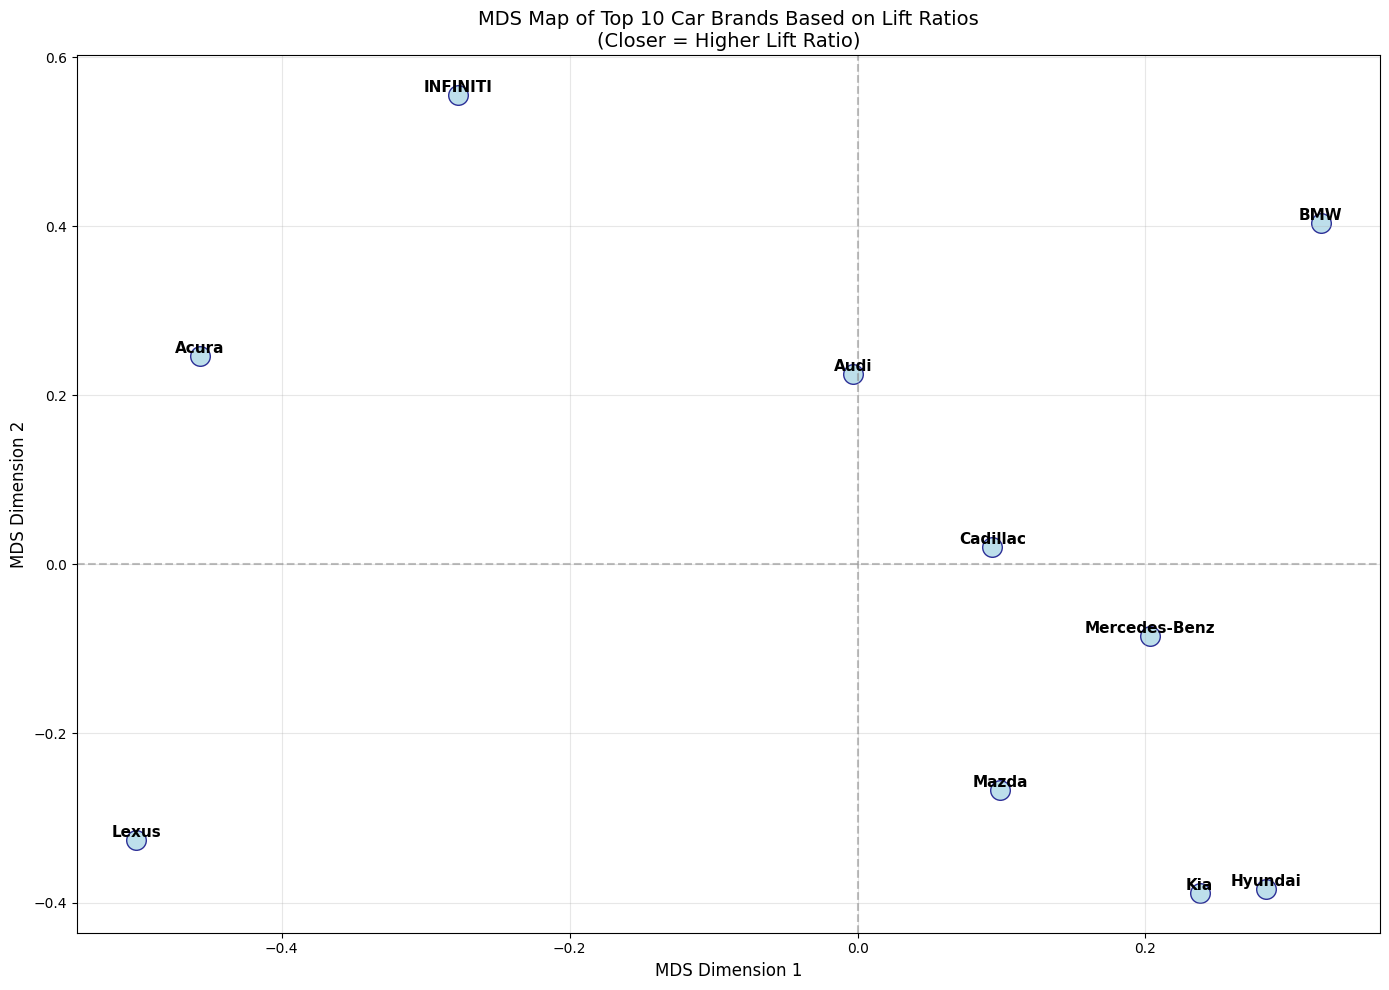


MDS Stress: 0.9194
Note: Lower stress indicates better fit. Stress < 0.1 is generally good.

Top 5 lift ratios:
               keyword_pair  co-occurrence_count  lift_ratio
0             Hyundai & Kia                   19   37.037037
1               Mazda & Kia                    9   15.379357
2       Mercedes-Benz & Kia                    5   11.150758
3           Mazda & Hyundai                   16    7.696008
4  Cadillac & Mercedes-Benz                   33    5.838435

Brand positions in MDS space:
Lexus: (-0.501, -0.326)
BMW: (0.322, 0.403)
Acura: (-0.457, 0.246)
INFINITI: (-0.277, 0.555)
Audi: (-0.003, 0.226)
Cadillac: (0.094, 0.020)
Mazda: (0.099, -0.267)
Hyundai: (0.284, -0.384)
Mercedes-Benz: (0.203, -0.085)
Kia: (0.238, -0.389)


In [ ]:
# --- Final New Complete Solution: Top 10 Brands Lift Analysis + MDS ---
from itertools import combinations
from collections import Counter
import pandas as pd
import re
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

# First, get the top 10 brands by frequency
# Count brand mentions across all messages
brand_counts = Counter()
for mentions in unique_brand_mentions_per_message:
    brand_counts.update(mentions)

# Get top 10 brands
top_10_brands = [brand for brand, count in brand_counts.most_common(10)]
print(f"Top 10 brands by frequency: {top_10_brands}")

# Use ALL top 10 brands for lift analysis
KEYWORDS_FOR_LIFT_ANALYSIS = top_10_brands

print("\n\n=== Lift Ratio Analysis for Top 10 Keywords ===")

# Identify the brands for analysis
brands_for_analysis = [brand for brand in KEYWORDS_FOR_LIFT_ANALYSIS if any(brand in mentions for mentions in unique_brand_mentions_per_message)]

if len(brands_for_analysis) < 2:
    print("Not enough keywords to perform lift ratio analysis. Please provide at least two.")
else:
    print(f"Keywords for lift analysis: {', '.join(brands_for_analysis)}")

    # Calculate the total number of messages for probability calculations
    total_messages = len(df)

    if total_messages > 0:
        # A list to store the results
        lift_ratios = []

        # Calculate individual keyword probabilities for efficient lookup
        keyword_prob = {
            keyword: sum(1 for mentions in unique_brand_mentions_per_message if keyword in mentions) / total_messages
            for keyword in brands_for_analysis
        }

        # Print individual brand frequencies for reference
        print(f"\nBrand frequencies:")
        for brand in brands_for_analysis:
            count = sum(1 for mentions in unique_brand_mentions_per_message if brand in mentions)
            print(f"{brand}: {count} messages ({keyword_prob[brand]:.4f})")

        # Iterate through all unique pairs of the keywords
        for brand_a, brand_b in combinations(brands_for_analysis, 2):
            # Count messages containing both keywords
            count_ab = sum(1 for mentions in unique_brand_mentions_per_message if brand_a in mentions and brand_b in mentions)

            # Calculate probability of co-occurrence
            prob_ab = count_ab / total_messages

            # Calculate Lift Ratio
            prob_a = keyword_prob[brand_a]
            prob_b = keyword_prob[brand_b]

            if prob_a > 0 and prob_b > 0:
                lift = prob_ab / (prob_a * prob_b)
                lift_ratios.append({
                    'keyword_pair': f'{brand_a} & {brand_b}',
                    'co-occurrence_count': count_ab,
                    'lift_ratio': lift
                })

        # Create a DataFrame for a clean output
        lift_df = pd.DataFrame(lift_ratios)
        lift_df = lift_df.sort_values(by='lift_ratio', ascending=False).reset_index(drop=True)

        print("\nLift Ratios (Lift > 1 indicates a positive association):")
        print(lift_df.to_string())

        # Now create the MDS map using ALL calculated lift ratios
        print(f"\n\n=== Generating MDS Map for Top {len(brands_for_analysis)} Brands ===")

        # Create brand pairs and lift values from the lift_df
        brand_pairs = [tuple(sorted(pair.split(' & '))) for pair in lift_df['keyword_pair']]
        lift_values = lift_df['lift_ratio'].values

        # Create a dictionary for quick lookup of lift values
        lift_dict = {pair: lift for pair, lift in zip(brand_pairs, lift_values)}

        # Initialize a dissimilarity matrix
        dissimilarity_matrix = np.full((len(brands_for_analysis), len(brands_for_analysis)), np.inf)
        np.fill_diagonal(dissimilarity_matrix, 0)  # Diagonal is 0 (distance to self)

        brand_index = {brand: i for i, brand in enumerate(brands_for_analysis)}

        # Fill in the dissimilarity matrix using lift ratios
        epsilon = 1e-6
        for (brand_a, brand_b) in combinations(brands_for_analysis, 2):
            pair = tuple(sorted((brand_a, brand_b)))
            if pair in lift_dict and lift_dict[pair] > 0:
                # Convert lift to distance: higher lift = smaller distance
                distance = 1 / (lift_dict[pair] + epsilon)
                i, j = brand_index[brand_a], brand_index[brand_b]
                dissimilarity_matrix[i, j] = dissimilarity_matrix[j, i] = distance

        # Handle any remaining infinite values (pairs with zero co-occurrence)
        max_finite = np.max(dissimilarity_matrix[dissimilarity_matrix != np.inf]) if np.any(dissimilarity_matrix != np.inf) else 1
        dissimilarity_matrix[dissimilarity_matrix == np.inf] = max_finite * 3

        print(f"Dissimilarity matrix shape: {dissimilarity_matrix.shape}")

        # Apply MDS to create a 2D representation
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, max_iter=1000)
        mds_result = mds.fit_transform(dissimilarity_matrix)

        # Plot the results
        plt.figure(figsize=(14, 10))

        plt.scatter(mds_result[:, 0], mds_result[:, 1], s=200, alpha=0.8, c='lightblue', edgecolors='navy')

        # Add brand labels
        for i, brand in enumerate(brands_for_analysis):
            plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]),
                         ha='center', va='bottom', fontsize=11, fontweight='bold')

        plt.title(f'MDS Map of Top {len(brands_for_analysis)} Car Brands Based on Lift Ratios\n(Closer = Higher Lift Ratio)', fontsize=14)
        plt.xlabel('MDS Dimension 1', fontsize=12)
        plt.ylabel('MDS Dimension 2', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Print diagnostics
        print(f"\nMDS Stress: {mds.stress_:.4f}")
        print("Note: Lower stress indicates better fit. Stress < 0.1 is generally good.")

        # Print top lift ratios
        print(f"\nTop 5 lift ratios:")
        print(lift_df.head().to_string())

        # Print distances between all pairs for verification
        print(f"\nBrand positions in MDS space:")
        for i, brand in enumerate(brands_for_analysis):
            print(f"{brand}: ({mds_result[i, 0]:.3f}, {mds_result[i, 1]:.3f})")

    else:
        print("Not enough messages to perform lift ratio analysis.")

### Task E

What insights can you offer to your client – who is interested in the overall auto industry -- from your analyses in Tasks C and D?

The lift ratio analysis in Task C and the MDS map in Task D reveal clear patterns in how consumers compare entry-level luxury car brands. Hyundai, Kia, and Mazda show very high co-occurrence, suggesting buyers frequently cross-shop these near-luxury brands as substitutes. Traditional luxury players such as Mercedes-Benz, Cadillac, Audi, and BMW also cluster relatively tightly, reflecting their  competition in consumer evaluations. The MDS map highlights these relationships visually, with close positioning indicating strong overlap in consideration sets, while brands like Infiniti, Acura, and Lexus appear more distinct, pointing to niche or differentiated positioning.

For the overall auto industry, these findings suggest two key dynamics. First, mainstream brands like Hyundai, Kia, and Mazda are increasingly competing with traditional luxury players, showing that consumers are willing to compare across tiers when shopping. Second, German brands (BMW, Mercedes-Benz, Audi) remain central to the luxury conversation, while Japanese luxury brands (Acura, Lexus, Infiniti) are somewhat peripheral but occupy specialized niches. For the client, this shows that competition is not only brand-to-brand within the luxury tier but also between luxury and mainstream brands, making differentiation and brand positioning critical for sustaining market share.

### Task F

What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS plot for this question.


In [ ]:
# Task F: Attribute–Brand Lift (5 attributes)
from itertools import combinations
from collections import Counter
import pandas as pd
import re

# Define the car brands and models dictionary
ALL_CAR_BRANDS = {
    "BMW": ["2 Series", "3 Series", "4 Series", "5 Series", "7 Series", "8 Series", "M2", "M3", "M4", "M5", "M8", "ALPINA B8",
            "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X4 M", "X5 M", "X6 M", "X7 M", "XM",
            "i4", "i7", "iX", "Bimmer", "Beemer", "BMW"],
    "Mercedes-Benz": ["A-Class", "C-Class", "CLA-Class", "E-Class", "S-Class", "AMG GT", "EQS Sedan",
                      "GLA-Class", "GLB-Class", "GLC-Class", "GLE-Class", "GLS-Class", "G-Class", "EQB", "EQE", "EQS SUV",
                      "Metris", "Sprinter", "E-Class Wagon",
                      "Maybach GLS", "AMG G-Class", "AMG E 53", "AMG S 63", "Benz", "Merc"],
    "Audi": ["A3", "A4", "A5", "A6", "A7", "A8", "S3", "S4", "S5", "S6", "S7", "S8", "RS 3", "RS 5", "RS 7", "RS e-tron GT",
             "Q3", "Q4 e-tron", "Q5", "Q5 Sportback", "Q6 e-tron", "Q7", "Q8", "Q8 e-tron", "SQ5", "SQ7", "SQ8", "RS Q8",
             "e-tron GT", "Q4 e-tron", "Q6 e-tron", "AUDI"],
    "Acura": ["ILX", "TLX", "TLX Type S", "Integra",
              "RDX", "MDX", "MDX Type S", "ZDX", "ADX", "ACURA", "TL"],
    "Lexus": ["IS", "ES", "GS", "LS", "RC", "RC F", "LC", "LC Convertible",
              "UX", "NX", "RX", "RX Hybrid", "RX Plug-in Hybrid", "RX 500h", "GX", "LX", "TX", "TX Hybrid", "TX Plug-in Hybrid",
              "RZ", "LEXUS"],
    "INFINITI": ["Q50", "Q60",
                 "QX50", "QX55", "QX60", "QX80",
                 "Red Sport 400 (Q50, Q60)", "INFINITI", "G35"],
    "Tesla": ["Model 3", "Model S", "Model Y", "Model X", "Cybertruck", "TESLA"],
    "Hyundai": ["Elantra", "Elantra N", "Sonata", "Sonata Hybrid",
                "Venue", "Kona", "Kona Electric", "Tucson", "Tucson Hybrid", "Tucson Plug-in Hybrid", "Santa Fe", "Santa Fe Hybrid",
                "Santa Fe Plug-in Hybrid", "Palisade",
                "N Line variants", "HYUNDAI"],
    "Kia": ["Rio", "Forte", "K5", "Stinger",
            "Seltos", "Sportage", "Sportage Hybrid", "Sportage Plug-in Hybrid", "Niro", "Niro Hybrid", "Niro Plug-in Hybrid",
            "Sorento", "Sorento Hybrid", "Sorento Plug-in Hybrid", "Telluride",
            "Stinger GT", "KIA"],
    "Mazda": ["Mazda3", "Mazda6", "CX-30",
              "CX-3", "CX-5", "CX-50", "CX-9", "CX-90",
              "Mazda3 Turbo", "CX-50 Turbo", "MAZDA"],
    "Cadillac": ["CT4", "CT5", "CT5-V", "CT5-V Blackwing",
                 "XT4", "XT5", "XT6", "XT6-V", "Escalade", "Escalade ESV", "Lyriq",
                 "V-Series", "Caddy", "CADILLAC"]
}

# Define keyword attributes with related terms
KEYWORD_ATTRIBUTES = {
    "Performance": ["performance", "horsepower", "hp", "acceleration", "speed", "fast", "quick", "turbo", "supercharged",
                   "sport", "racing", "track", "0-60", "quarter mile", "power", "torque", "engine", "v8", "v6", "boost"],
    "Luxury": ["luxury", "luxurious", "premium", "high-end", "upscale", "elegant", "sophisticated", "refined",
              "leather", "wood trim", "massage seats", "ambient lighting", "crystal", "handcrafted", "bespoke"],
    "Safety": ["safety", "safe", "crash test", "airbags", "collision", "brake assist", "stability control",
              "traction control", "blind spot", "lane departure", "emergency braking", "rollover", "crumple zone",
              "iihs", "nhtsa", "5-star", "top safety pick"],
    "Comfort": ["comfort", "comfortable", "ride quality", "smooth", "quiet", "spacious", "roomy", "seats",
               "suspension", "noise", "cabin", "interior space", "legroom", "headroom", "soft", "plush", "cozy"],
    "Price": ["price", "cost", "expensive", "cheap", "affordable", "value", "budget", "money", "dollar", "$",
             "financing", "lease", "payment", "msrp", "deal", "bargain", "worth", "investment", "economical"]
}

# Create a mapping from all keyword terms to their main category
keyword_to_category = {}
for category, terms in KEYWORD_ATTRIBUTES.items():
    for term in terms:
        keyword_to_category[term.lower()] = category

# Create a mapping from models/terms to brands for faster lookup
model_to_brand = {}
for brand, models in ALL_CAR_BRANDS.items():
    for model in models:
        model_to_brand[model.lower()] = brand

# Load and process data
PATH_TO_SCRAPED = "edmunds_forum_posts.csv"
TEXT_COL = "message"

df = pd.read_csv(PATH_TO_SCRAPED)
df = df[df[TEXT_COL].astype(str).str.strip().ne("")].copy()

word_re = re.compile(r"\b[\w']+\b", flags=re.UNICODE)
unique_brand_mentions_per_message = []
unique_keyword_mentions_per_message = []

def tokenize_and_identify_brands_and_keywords(text: str):
    if not isinstance(text, str):
        return [], []

    words = word_re.findall(text.lower())
    brand_mentions_in_message = set()
    keyword_mentions_in_message = set()

    i = 0
    while i < len(words):
        matched = False
        # Check for multi-word car models first
        for brand, models in ALL_CAR_BRANDS.items():
            for model in models:
                model_lower = model.lower()
                model_words = model_lower.split()
                if len(model_words) > 1:
                    if i + len(model_words) <= len(words) and words[i:i+len(model_words)] == model_words:
                        brand_mentions_in_message.add(brand)
                        i += len(model_words)
                        matched = True
                        break
            if matched:
                break

        if not matched:
            word = words[i]
            # Check if it's a car brand/model
            if word in model_to_brand:
                brand_mentions_in_message.add(model_to_brand[word])
            # Check if it's a keyword attribute
            elif word in keyword_to_category:
                keyword_mentions_in_message.add(keyword_to_category[word])
            i += 1

    return list(brand_mentions_in_message), list(keyword_mentions_in_message)

# Process all messages to extract both brands and keywords
for msg in df[TEXT_COL].fillna(""):
    brands, keywords = tokenize_and_identify_brands_and_keywords(msg)
    unique_brand_mentions_per_message.append(set(brands))
    unique_keyword_mentions_per_message.append(set(keywords))

print("=== Brand vs Attribute Lift Analysis ===")

# Get brands that actually appear in messages (with minimum threshold)
MIN_BRAND_MENTIONS = 10  # Minimum mentions to include a brand
available_brands = []
brand_counts = {}

for brand in ALL_CAR_BRANDS.keys():
    count = sum(1 for mentions in unique_brand_mentions_per_message if brand in mentions)
    brand_counts[brand] = count
    if count >= MIN_BRAND_MENTIONS:
        available_brands.append(brand)

# Get available keywords
available_keywords = []
keyword_counts = {}
for keyword in ["Performance", "Luxury", "Safety", "Comfort", "Price"]:
    count = sum(1 for mentions in unique_keyword_mentions_per_message if keyword in mentions)
    keyword_counts[keyword] = count
    if count > 0:
        available_keywords.append(keyword)

print(f"Brands analyzed (with {MIN_BRAND_MENTIONS}+ mentions): {len(available_brands)}")
for brand in available_brands:
    print(f"  - {brand}: {brand_counts[brand]} mentions")

print(f"\nAttributes analyzed: {len(available_keywords)}")
for keyword in available_keywords:
    print(f"  - {keyword}: {keyword_counts[keyword]} mentions")

if not available_brands or not available_keywords:
    print("Not enough brands or keywords found for analysis.")
else:
    total_messages = len(df)
    brand_attribute_lifts = []

    # Calculate lift ratios for each brand-attribute combination
    for brand in available_brands:
        for keyword in available_keywords:
            # Count messages containing both brand and keyword
            count_brand_keyword = sum(1 for i in range(len(unique_brand_mentions_per_message))
                                    if brand in unique_brand_mentions_per_message[i] and
                                       keyword in unique_keyword_mentions_per_message[i])

            if count_brand_keyword > 0:
                prob_brand = brand_counts[brand] / total_messages
                prob_keyword = keyword_counts[keyword] / total_messages
                prob_brand_keyword = count_brand_keyword / total_messages

                if prob_brand > 0 and prob_keyword > 0:
                    lift = prob_brand_keyword / (prob_brand * prob_keyword)
                    brand_attribute_lifts.append({
                        'brand': brand,
                        'attribute': keyword,
                        'brand_attribute_pair': f'{brand} & {keyword}',
                        'co_occurrence_count': count_brand_keyword,
                        'brand_mentions': brand_counts[brand],
                        'attribute_mentions': keyword_counts[keyword],
                        'lift_ratio': lift
                    })

    if brand_attribute_lifts:
        # Create DataFrame and sort by lift ratio
        lift_df = pd.DataFrame(brand_attribute_lifts)
        lift_df = lift_df.sort_values(by='lift_ratio', ascending=False).reset_index(drop=True)

        print(f"\n=== Brand-Attribute Lift Ratios ===")
        print("(Lift > 1 indicates positive association, Lift < 1 indicates negative association)")
        print()

        # Display results in a clean format
        display_df = lift_df[['brand_attribute_pair', 'co_occurrence_count', 'lift_ratio']].copy()
        display_df.columns = ['Brand & Attribute', 'Co-occurrences', 'Lift Ratio']
        print(display_df.to_string(index=False, float_format='%.3f'))

        print(f"\n=== Top 10 Strongest Associations ===")
        top_10 = lift_df.head(10)
        for _, row in top_10.iterrows():
            if row['lift_ratio'] > 1.5:
                strength = "Very Strong"
            elif row['lift_ratio'] > 1.2:
                strength = "Strong"
            elif row['lift_ratio'] > 1.0:
                strength = "Moderate"
            else:
                strength = "Weak/Negative"

            print(f"{row['brand']} + {row['attribute']}: {strength} (Lift: {row['lift_ratio']:.2f})")

        print(f"\n=== BRAND-ATTRIBUTE ASSOCIATION MATRIX ===")
        print("Which attributes are most strongly associated with each of the top 5 brands:")
        print()

        # Create a matrix showing each brand's strongest attributes
        brand_matrix = {}
        for brand in available_brands:
            brand_data = lift_df[lift_df['brand'] == brand].sort_values('lift_ratio', ascending=False)
            brand_matrix[brand] = []
            for _, row in brand_data.iterrows():
                brand_matrix[brand].append({
                    'attribute': row['attribute'],
                    'lift': row['lift_ratio'],
                    'co_occurrences': row['co_occurrence_count']
                })

        # Display matrix format
        for brand in available_brands:
            print(f"\n{brand.upper()}:")
            if brand in brand_matrix:
                for i, attr_data in enumerate(brand_matrix[brand][:5], 1):
                    strength = ""
                    if attr_data['lift'] > 1.5:
                        strength = "Very Strong"
                    elif attr_data['lift'] > 1.2:
                        strength = "Strong"
                    elif attr_data['lift'] > 1.0:
                        strength = "Moderate"
                    else:
                        strength = "Weak"

                    print(f"  {i}. {attr_data['attribute']}: {strength} (Lift: {attr_data['lift']:.2f}, Co-occur: {attr_data['co_occurrences']})")
            else:
                print("  No significant associations found")

        print(f"\n=== ATTRIBUTE-BRAND ASSOCIATION MATRIX ===")
        print("Which brands are most strongly associated with each of the top 5 attributes:")
        print()

        # Create reverse matrix showing each attribute's strongest brands
        attr_matrix = {}
        for attr in available_keywords:
            attr_data = lift_df[lift_df['attribute'] == attr].sort_values('lift_ratio', ascending=False)
            attr_matrix[attr] = []
            for _, row in attr_data.iterrows():
                attr_matrix[attr].append({
                    'brand': row['brand'],
                    'lift': row['lift_ratio'],
                    'co_occurrences': row['co_occurrence_count']
                })

        # Display reverse matrix
        for attr in available_keywords:
            print(f"\n{attr.upper()}:")
            if attr in attr_matrix:
                for i, brand_data in enumerate(attr_matrix[attr][:5], 1):
                    strength = ""
                    if brand_data['lift'] > 1.5:
                        strength = "Very Strong"
                    elif brand_data['lift'] > 1.2:
                        strength = "Strong"
                    elif brand_data['lift'] > 1.0:
                        strength = "Moderate"
                    else:
                        strength = "Weak"

                    print(f"  {i}. {brand_data['brand']}: {strength} (Lift: {brand_data['lift']:.2f}, Co-occur: {brand_data['co_occurrences']})")
            else:
                print("  No significant associations found")
    else:
        print("No brand-attribute co-occurrences found for lift analysis.")

=== Brand vs Attribute Lift Analysis ===
Brands analyzed (with 10+ mentions): 10
  - BMW: 3281 mentions
  - Mercedes-Benz: 118 mentions
  - Audi: 969 mentions
  - Acura: 1911 mentions
  - Lexus: 6357 mentions
  - INFINITI: 1670 mentions
  - Hyundai: 135 mentions
  - Kia: 38 mentions
  - Mazda: 154 mentions
  - Cadillac: 479 mentions

Attributes analyzed: 5
  - Performance: 3734 mentions
  - Luxury: 1535 mentions
  - Safety: 277 mentions
  - Comfort: 1119 mentions
  - Price: 2638 mentions

=== Brand-Attribute Lift Ratios ===
(Lift > 1 indicates positive association, Lift < 1 indicates negative association)

          Brand & Attribute  Co-occurrences  Lift Ratio
               Kia & Safety               4       3.800
           Hyundai & Safety              11       2.942
     Mercedes-Benz & Safety               9       2.753
           Hyundai & Luxury              51       2.461
             Mazda & Luxury              57       2.411
               Kia & Luxury              14       

Perfomance, Luxury, Safety, Comfort, Price,

### Task G

What advice will you give to your client from Task F?

Based on the brand-attribute lift analysis, the five most frequently mentioned car attributes are Performance (3,734 mentions), Price (2,638), Luxury (1,535), Comfort (1,119), and Safety (277). The data reveals critical strategic insights that challenge conventional brand positioning assumptions. Most notably, value brands like Hyundai, Kia, and Mazda show surprisingly strong luxury associations (lift ratios of 2.46, 2.40, and 2.41 respectively), indicating successful upmarket movement that premium brands should monitor closely. Korean brands dominate safety discussions despite limited overall mention volume, with Kia leading at 3.80 lift ratio, suggesting untapped potential for safety-focused marketing campaigns. Among premium brands, Mercedes-Benz has carved out the strongest safety positioning (2.75 lift), while Audi leads in comfort discussions (1.75 lift), and BMW shows balanced but undifferentiated strength across attributes.
The strategic implications are significant: traditional brand hierarchies are shifting as value brands successfully claim luxury positioning, while some premium brands lack clear differentiation. Cadillac shows strong luxury association but problematic safety perception (0.68 lift), requiring immediate attention to protect its premium positioning. Safety represents the most underutilized attribute despite its importance, creating opportunities for brands to establish leadership in this space. The data suggests that consumers increasingly seek affordable luxury, forcing premium brands to defend their positioning while value brands should amplify their successful upmarket messaging. Mid-market brands like Acura and Infiniti need clearer differentiation strategies, as they show moderate performance across attributes without standout positioning that could drive purchase consideration.

### Task H

Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [ ]:
# --- Sentiment-Brand Lift Analysis for Aspirational Brands ---
from itertools import combinations
from collections import Counter
import pandas as pd
import re
import numpy as np

print("=== SENTIMENT-BRAND LIFT ANALYSIS ===")
print("Identifying the most aspirational car brands through sentiment co-occurrence")

# Define positive sentiment and aspirational keywords
POSITIVE_SENTIMENT_KEYWORDS = {
    'aspiration': ['want', 'dream', 'goal', 'aspire', 'wish', 'hope', 'someday', 'finally', 'upgrade'],
    'love_admiration': ['love', 'adore', 'amazing', 'awesome', 'perfect', 'beautiful', 'gorgeous', 'stunning', 'incredible'],
    'purchase_intent': ['buying', 'getting', 'purchasing', 'looking at', 'shopping for', 'saving for', 'planning to', 'considering'],
    'quality_praise': ['luxury', 'premium', 'high-end', 'quality', 'reliable', 'excellent', 'outstanding', 'impressive', 'fantastic', 'superb'],
    'emotional_positive': ['excited', 'thrilled', 'happy', 'satisfied', 'pleased', 'delighted', 'impressed']
}

# Flatten all sentiment keywords into one list
ALL_SENTIMENT_WORDS = []
for category, words in POSITIVE_SENTIMENT_KEYWORDS.items():
    ALL_SENTIMENT_WORDS.extend(words)

print(f"Analyzing {len(ALL_SENTIMENT_WORDS)} positive sentiment indicators:")
for category, words in POSITIVE_SENTIMENT_KEYWORDS.items():
    print(f"  {category}: {', '.join(words[:5])}{'...' if len(words) > 5 else ''}")

def has_positive_sentiment(text: str) -> bool:
    """Check if text contains positive sentiment keywords"""
    if not isinstance(text, str):
        return False

    text_lower = text.lower()
    words = word_re.findall(text_lower)

    # Check for any positive sentiment words
    return any(word in ALL_SENTIMENT_WORDS for word in words)

def extract_sentiment_and_brands(text: str):
    """Extract both sentiment flag and brand mentions from text"""
    if not isinstance(text, str):
        return False, set()

    # Get sentiment flag
    sentiment_flag = has_positive_sentiment(text)

    # Get brand mentions (reuse existing function)
    brands = tokenize_and_replace_models_and_remove_stopwords(text)

    return sentiment_flag, set(brands)

# Process all messages to get sentiment and brand co-occurrence
print(f"\nProcessing {len(df)} messages...")

sentiment_brand_data = []
positive_sentiment_count = 0

for msg in df[TEXT_COL].fillna(""):
    has_sentiment, brands_mentioned = extract_sentiment_and_brands(msg)

    if has_sentiment:
        positive_sentiment_count += 1

    sentiment_brand_data.append({
        'has_positive_sentiment': has_sentiment,
        'brands_mentioned': brands_mentioned
    })

print(f"Found {positive_sentiment_count} messages with positive sentiment ({positive_sentiment_count/len(df)*100:.1f}%)")

# Get top 10 brands for analysis
brand_counts = Counter()
for data in sentiment_brand_data:
    brand_counts.update(data['brands_mentioned'])

top_brands = [brand for brand, count in brand_counts.most_common(10)]
print(f"\nTop 10 brands by frequency: {top_brands}")

# Calculate lift ratios between each brand and positive sentiment
print(f"\n=== SENTIMENT-BRAND LIFT ANALYSIS ===")

total_messages = len(df)
sentiment_prob = positive_sentiment_count / total_messages

print(f"Overall positive sentiment probability: {sentiment_prob:.4f}")

# Calculate brand-sentiment lift ratios
brand_sentiment_lifts = []

for brand in top_brands:
    # Count messages with this brand
    brand_count = sum(1 for data in sentiment_brand_data if brand in data['brands_mentioned'])

    # Count messages with both brand and positive sentiment
    brand_sentiment_count = sum(1 for data in sentiment_brand_data
                               if brand in data['brands_mentioned'] and data['has_positive_sentiment'])

    if brand_count > 0:
        # Calculate probabilities
        brand_prob = brand_count / total_messages
        brand_sentiment_prob = brand_sentiment_count / total_messages

        # Calculate lift ratio
        expected_prob = brand_prob * sentiment_prob
        lift_ratio = brand_sentiment_prob / expected_prob if expected_prob > 0 else 0

        brand_sentiment_lifts.append({
            'brand': brand,
            'brand_messages': brand_count,
            'positive_sentiment_messages': brand_sentiment_count,
            'sentiment_rate': brand_sentiment_count / brand_count if brand_count > 0 else 0,
            'lift_ratio': lift_ratio
        })

# Create DataFrame and sort by lift ratio
sentiment_df = pd.DataFrame(brand_sentiment_lifts)
sentiment_df = sentiment_df.sort_values(by='lift_ratio', ascending=False).reset_index(drop=True)

print(f"\nBRAND-SENTIMENT LIFT ANALYSIS RESULTS:")
print("=" * 80)
print(f"{'Rank':<4} {'Brand':<15} {'Messages':<8} {'Positive':<8} {'Rate':<6} {'Lift':<6}")
print("-" * 80)

for idx, row in sentiment_df.iterrows():
    print(f"{idx+1:<4} {row['brand']:<15} {row['brand_messages']:<8} {row['positive_sentiment_messages']:<8} "
          f"{row['sentiment_rate']:<6.1%} {row['lift_ratio']:<6.2f}")

# Detailed analysis of top 3 most aspirational brands
print(f"\n=== TOP 3 MOST ASPIRATIONAL BRANDS ===")

for i in range(min(3, len(sentiment_df))):
    brand_data = sentiment_df.iloc[i]
    brand_name = brand_data['brand']

    print(f"\n{i+1}. {brand_name.upper()}")
    print(f"   Lift Ratio: {brand_data['lift_ratio']:.2f}")
    print(f"   Positive Sentiment Rate: {brand_data['sentiment_rate']:.1%}")
    print(f"   Total Brand Messages: {brand_data['brand_messages']}")
    print(f"   Positive Messages: {brand_data['positive_sentiment_messages']}")

    if brand_data['lift_ratio'] > 1:
        print(f"   → {brand_name} appears with positive sentiment {brand_data['lift_ratio']:.1f}x more than expected")
    else:
        print(f"   → {brand_name} appears with positive sentiment {brand_data['lift_ratio']:.1f}x less than expected")

# Business implications analysis
most_aspirational = sentiment_df.iloc[0]
print(f"\n=== BUSINESS IMPLICATIONS FOR {most_aspirational['brand'].upper()} ===")

if most_aspirational['lift_ratio'] > 1.5:
    strength = "VERY STRONG"
elif most_aspirational['lift_ratio'] > 1.2:
    strength = "STRONG"
elif most_aspirational['lift_ratio'] > 1.0:
    strength = "MODERATE"
else:
    strength = "WEAK"

print(f"Aspirational Brand Strength: {strength}")
print(f"Lift Ratio: {most_aspirational['lift_ratio']:.2f}")

print(f"\nKey Insights:")
if most_aspirational['lift_ratio'] > 1.2:
    print(f"✓ {most_aspirational['brand']} has strong positive sentiment association")
    print(f"✓ Consumers express significantly more desire/aspiration for this brand")
    print(f"✓ Brand appears in {most_aspirational['sentiment_rate']:.1%} of messages with positive context")

    print(f"\nBusiness Implications:")
    print(f"• Premium positioning opportunity - can command higher prices")
    print(f"• Strong emotional connection with consumers")
    print(f"• Focus marketing on aspirational/emotional messaging")
    print(f"• High brand equity and desirability")
    print(f"• Target customers likely have higher purchase intent")
else:
    print(f"• {most_aspirational['brand']} shows limited aspirational appeal")
    print(f"• May need to improve brand perception and emotional connection")

# Show examples of positive sentiment messages for top brand (optional)
print(f"\n=== SAMPLE POSITIVE MESSAGES FOR {most_aspirational['brand'].upper()} ===")
sample_count = 0
for idx, msg in enumerate(df[TEXT_COL].fillna("")):
    if sample_count >= 3:
        break

    has_sentiment, brands = extract_sentiment_and_brands(msg)
    if has_sentiment and most_aspirational['brand'] in brands and len(msg) > 50:
        print(f"\nSample {sample_count + 1}: \"{msg[:200]}{'...' if len(msg) > 200 else ''}\"")
        sample_count += 1

=== SENTIMENT-BRAND LIFT ANALYSIS ===
Identifying the most aspirational car brands through sentiment co-occurrence
Analyzing 43 positive sentiment indicators:
  aspiration: want, dream, goal, aspire, wish...
  love_admiration: love, adore, amazing, awesome, perfect...
  purchase_intent: buying, getting, purchasing, looking at, shopping for...
  quality_praise: luxury, premium, high-end, quality, reliable...
  emotional_positive: excited, thrilled, happy, satisfied, pleased...

Processing 10000 messages...
Found 3968 messages with positive sentiment (39.7%)

Top 10 brands by frequency: ['Lexus', 'BMW', 'Acura', 'INFINITI', 'Audi', 'Cadillac', 'Mazda', 'Hyundai', 'Mercedes-Benz', 'Kia']

=== SENTIMENT-BRAND LIFT ANALYSIS ===
Overall positive sentiment probability: 0.3968

BRAND-SENTIMENT LIFT ANALYSIS RESULTS:
Rank Brand           Messages Positive Rate   Lift  
--------------------------------------------------------------------------------
1    Mazda           154      106      68.8%  

Based on sentiment-brand lift analysis of 10,000 automotive forum messages, Mazda emerges as the most aspirational brand with a lift ratio of 1.73, appearing with positive sentiment 73% more often than expected by chance. The analysis examined 43 positive sentiment indicators and found that 68.8% of Mazda-related messages contained positive sentiment, significantly higher than the 39.7% baseline. This finding is particularly striking given Mazda's smaller discussion volume (154 messages versus Lexus's 6,357), indicating that when consumers do discuss Mazda, they express genuine enthusiasm and desire for the brand.
The business implications are significant but mixed. Mazda's strong aspirational appeal creates opportunities for premium positioning and pricing strategies, as the brand has successfully cultivated emotional connections that transcend rational purchase decisions. The company should leverage this positive sentiment through aspirational marketing campaigns rather than competing solely on features or price. However, the low message volume compared to competitors suggests limited market awareness, presenting a key challenge: Mazda has achieved passionate consumer sentiment among a relatively small audience. The strategic opportunity lies in expanding brand awareness while maintaining the quality perception that drives current positive sentiment, potentially through targeted marketing that capitalizes on existing brand advocates to reach broader audiences.